#### Importing Libraries required for building the model


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

#### Fetching the raw data and providing input dimensions of the images for the model 


In [2]:
train_dir = 'F:\\Real-Time Image Detection\\train\\'
test_dir = 'F:\\Real-Time Image Detection\\test\\'

row = 48
col = 48
classes = len(os.listdir('F:\\Real-Time Image Detection\\train'))

#### Creating Training and Testing Datasets from raw data


In [3]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t\t", len(os.listdir(train_dir+"\\"+folder)), "image")
    train_count.append(len(os.listdir(train_dir+"\\"+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+"\\"+folder)), "images")
    test_count.append(len(os.listdir(test_dir+"\\"+folder)))

Train Set :
angry folder contains			 3995 image
disgust folder contains			 436 image
fear folder contains			 4097 image
happy folder contains			 7215 image
neutral folder contains			 4965 image
sad folder contains			 4830 image
surprise folder contains			 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


#### Data Augmentation 

In [4]:
train_data = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   horizontal_flip=False)

training_set = train_data.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_data = ImageDataGenerator(rescale=1./255)
test_set = test_data.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=False,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Fetching classes detected from train and test datasets


In [5]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

#### Examples of classnames offered for usage in output


In [6]:
classnames = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"] # These classes should be folder names

#### CNN Model architecture


In [7]:
def get_CNN_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax')) 

    model.compile(optimizer=tf.keras.optimizers.SGD(0.01), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

#### Model Execution


In [8]:
fernet = get_CNN_model((row,col,1), classes)

#### Epoch Characteristics 


In [9]:
save_model_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=save_model_path,         # To store the highest validation accuracy result while training the model
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy',       # To early stopping is used to stop training the model once validation accuracy starts to degrade
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',   # To reduce the learning rate if validation accuracy is not improving
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #To visualize the training summary for our model
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

#### Model training with 60 epochs


In [10]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=53,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/53
448/448 [==============================] - ETA: 0s - loss: 7.4869 - accuracy: 0.2725
Epoch 1: val_loss improved from inf to 7.03359, saving model to ferNet.h5
448/448 [==============================] - 1035s 2s/step - loss: 7.4869 - accuracy: 0.2725 - val_loss: 7.0336 - val_accuracy: 0.3103 - lr: 0.0100
Epoch 2/53
448/448 [==============================] - ETA: 0s - loss: 6.3005 - accuracy: 0.3369
Epoch 2: val_loss improved from 7.03359 to 5.82556, saving model to ferNet.h5
448/448 [==============================] - 794s 2s/step - loss: 6.3005 - accuracy: 0.3369 - val_loss: 5.8256 - val_accuracy: 0.3895 - lr: 0.0100
Epoch 3/53
448/448 [==============================] - ETA: 0s - loss: 5.4908 - accuracy: 0.3697
Epoch 3: val_loss improved from 5.82556 to 5.07311, saving model to ferNet.h5
448/448 [==============================] - 813s 2s/step - loss: 5.4908 - accuracy: 0.3697 - val_loss: 5.0731 - val_accuracy: 0.4076 - lr: 0.0100
Epoch 4/53
448/448 [==========================

#### Saving the model after complete execution


In [ ]:
fernet.save("CNN_Model.h5")

### Representing model accuracy graphically

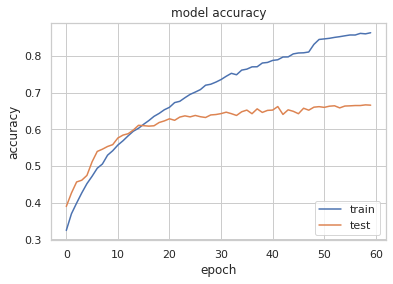

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

### Representing model loss graphically

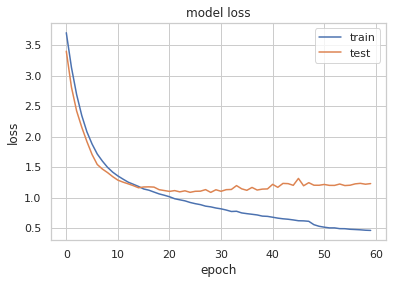

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

### Model Testing
#### Loading the trained model

In [9]:
model = tf.keras.models.load_model('ferNet.h5')

### Getting Final Train Accuracy and Validation Accuracy

In [11]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set) 
print("Final train accuracy = {:.2f} , Validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 42s 369ms/step - loss: 1.4750 - accuracy: 0.6388
Final train accuracy = 90.19 , Validation accuracy = 63.88


### Confusion Matrix

In [17]:
import random
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = training_set.class_indices
class_label = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

449/449 [==============================] - 170s 379ms/step
Confusion Matrix
[[ 606   54  535 1000  729  656  415]
 [  65    8   60  114   71   75   43]
 [ 655   68  546  998  720  658  452]
 [1060   76  932 1847 1288 1179  833]
 [ 767   67  681 1238  850  797  565]
 [ 723   85  618 1244  871  779  510]
 [ 470   47  458  768  587  489  352]]


#### Classification Report depicting precision scores for all sentiments

In [26]:
# print('Classification Report\n')
# precision_score()
# target_names = list(class_label.values())
# print(classification_report(training_set.classes, y_pred, target_names=target_names))
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(classnames)
precision = precision_score(training_set.classes, y_pred, average=None)
print("\nPrecision : ", precision)
recall_score = recall_score(training_set.classes, y_pred, average=None)
print("\nRecall Score : ", recall_score)
f1_score = f1_score(training_set.classes, y_pred, average=None)
print("\nF1 score : ", f1_score)
accuracy = accuracy_score(training_set.classes, y_pred)
print("\nAccuracy Score : ", accuracy)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Precision :  [0.13943856 0.01975309 0.14255875 0.25620752 0.16614543 0.16814159
 0.11104101]

Recall Score :  [0.15168961 0.01834862 0.13326825 0.25599446 0.17119839 0.16128364
 0.11100599]

F1 score :  [0.14530632 0.01902497 0.13775703 0.25610094 0.16863406 0.16464123
 0.1110235 ]

Accuracy Score :  0.1737434254066669


In [14]:
image = cv2.imread('C:\\Users\\Pranesh\\Downloads\\WhatsApp Image 2022-12-28 at 22.48.45.jpeg', cv2.IMREAD_GRAYSCALE)

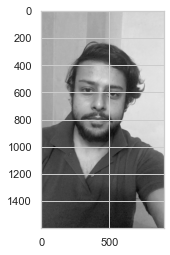

In [15]:
plt.imshow(image,cmap='gray')
plt.show()

In [16]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=model.predict(img) 
result=np.argmax(predict_x,axis=1)
classnames[result[0]]

1/1 [==============================] - 0s 78ms/step


'happy'

#### Activating Real-Time Camera for Face Detection

In [40]:
!python create_data.py

In [41]:
Data_dir = r"C:\\Real-Time Image Detection\\Face_Data\\"
import glob

In [18]:
ext = ['png', 'jpeg', 'jpg']    # Add image formats here
files = []
[files.extend(glob.glob(Data_dir + '*.' + e)) for e in ext]
images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files]
print(len(images))

99


In [19]:
img_out = []
for i in range(len(images)):
    img_out.append(images[i])

In [20]:
len(img_out)
pred_out = []

In [21]:
def img_size(image):
    image = cv2.resize(image,(48,48))
    img=np.array(image)
    img=img.reshape(1,48,48,1)
    pred_out.append(model.predict(img)) 

In [22]:
for i in range(len(img_out)):
    img_size(img_out[i])

1/1 [==============================] - 0s 47ms/step


In [23]:
pred_scores = []
for i in range(len(pred_out)):
    pred_scores.append(np.argmax(pred_out[i],axis=1))

In [24]:
sent_out = []
for i in range(len(pred_scores)):
    sent_out.append(classnames[pred_scores[i][0]])

In [25]:
# print(sent_out)
print(len(sent_out))

99


In [26]:
dc = 0  # negative emotion count
hc = 0  # positive emotion count
suc = 0 # surprise count

In [27]:
for i in range(len(sent_out)):
  if(sent_out[i] == 'angry' or sent_out[i] == 'disgust' or sent_out[i] == 'sad' or sent_out[i] == 'fear'):
      dc += 1
  elif (sent_out[i] == 'happy' or sent_out[i] == 'neutral'):
      hc += 1
  elif (sent_out[i] == 'surprise'):
      suc += 1
print("Sad Emotions : ", dc)
print("Happy Emotions : ", hc)
print("Surprise Emotions : ", suc)

Sad Emotions :  22
Happy Emotions :  29
Surprise Emotions :  48


In [34]:
pos_rate = round((hc / (dc + hc + suc)), 1) * 100
neg_rate = round((dc / (dc + hc + suc)), 2) * 100

In [38]:
print("\nNegative emotions : ", neg_rate, "%")
print("\nPositive emotions : ", pos_rate, "%")


Negative emotions :  22.0 %

Positive emotions :  30.0 %


In [36]:
if (neg_rate <= 30.0):
  if(neg_rate <= 5.0):
    print("Coool !! You have a great life ahead.\nStay strong and Stay safe")
  else:
    print("***   MILD DEPRESSION  ***")
    
  if (neg_rate <= 10.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tEverything is a-okay! There's absolutely nothing wrong 😁😁\n\t\tYou're probably cuddling a fluffy kitten right now")
  
  elif (neg_rate > 10.0 and neg_rate <= 20.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are a bit frustated and disappointed\n\t\tBut you're easily distracted and cheered with little effort 😁😁")
  
  elif (neg_rate > 20.0 and neg_rate <= 30.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tThings are bothering you but you're coping up\n\t\tYou might be over tired and hungry\n\t\tThe emotional equivalent of a headache 😁😁")
  
elif (neg_rate > 30.0 and neg_rate <= 60.0):
  print("***   MODERATE DEPRESSION  ***")
  
  if (neg_rate > 30.0 and neg_rate <= 40.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tToday is slighly a bad for you.\n\t\tYou still have the skills to get through it, but be gentle with yourself\n\t\tUse self-care strategies 😁😁")

  elif (neg_rate > 40.0 and neg_rate <= 50.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYour mental health is starting to impact your everyday life.\n\t\tEasy things are becoming difficult")
  
  elif (neg_rate > 50.0 and neg_rate <= 60.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are not able to do things the way usually you do them due to your mental health.\n\t\tImpulsive and compulsive thoughts might be difficult to cope with")
  
elif (neg_rate > 60.0 and neg_rate <= 100.0):
  print("***   SEVERE DEPRESSION  ***")
  if (neg_rate > 60.0 and neg_rate <= 70.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are loosing interests in the activities that were used to be enjoyable.\n\t\tYou should definitely seek help\n\t\tThis is becoming serious ☹☹")
  
  elif (neg_rate > 70.0 and neg_rate <= 80.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou can't ignore your struggles now, It's HIGH time!.\n\t\tYou may have issues sleeping, eating, having fun, socializing and work/study\n\t\tYour mental health is affecting almost all parts of your life ☹☹")

  elif (neg_rate > 80.0 and neg_rate <= 90.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are at a critical point !!!.\n\t\tYou aren't functioning anymore and need urgent help.\n\t\tYou maybe a risk to yourself or others if left untreated ☹☹")

  elif (neg_rate > 90.0 and neg_rate <= 100.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tThe worst mental and emotional distress possible.\n\t\tYou can't imagine things getting any better now and you might think it's all over for you (SUICIDE).\n\t\tContact crisis line or get started for the treatment immediately. ☹☹")

  

***   MILD DEPRESSION  ***

Depression Scale Detected :  2.2 

My Response :	Things are bothering you but you're coping up
		You might be over tired and hungry
		The emotional equivalent of a headache 😁😁


#### Remove files from the directory once done

In [39]:
dir = 'C:\\Real-Time Image Detection\\Face_Data\\'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))